# Sentiment analysis by using two different algorithms (models)

In this project, we will compare two models in order to detect the sentiment of Twitter posts. Data was collected from Twitter, where **1000 posts** with the search term "economy" between 01.10.2022 and 11.10.2022 were collected.

These two models are namely: VADER and roBERTa:
- **VADER** is a lexicon-based (or rule-based) model. Breifly, this model has its own dictionary (list of negative and positive words), and it tries to find the words from the text. Consequently
it assigns scores depending on found words. Custom words can be added to the dictionary.
- **Twitter-roBERTa** is a deep learning based model, which was fine-tuned with ~124 million tweets for Twitter sentiment analysis.

Both models does not require  *training*, i.e. they can be used directly out of package. However, preprocessing of text needed for both models, though preprocessing for roBERTa is minimalistic.

## 1. Packages and Data

In [1]:
# necessary libararies
# this extension is very usefull to autoformat your code. if black extension of Jupyter is not installed, install it first
%load_ext jupyter_black
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer, AutoConfig
from scipy.special import softmax
from nltk.sentiment.vader import SentimentIntensityAnalyzer

pd.set_option("max_colwidth", 200)

In [2]:
# read the data file which is in JSON format
df = pd.read_json(
    "economy_tweets.json",
    lines=True,
)
# since we are only interested in the content of the tweets, we will select it
df = df[["content"]]
df["content"] = df["content"].replace(r"\n", " ", regex=True)
df.head()

,content
0,"@POTUS “Because of my economic plan, we’re on the right track to building an economy that works for everyone.“ https://t.co/w5wgPzhCh8"
1,"The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!"
2,"INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta..."
3,@Sublimegaucho @csilverandgold The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of ...
4,"The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂"


## 2. Sentiment analysis with roBERTa model
In this section we will import **Twitter-roBERTa-base for Sentiment Analysis** from 
[Huggingface](https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment-latest?text=The+solution+for+a+beautiful%2C+sustainable%2C+abundant+and+free+world+is+a+library+economy%21+Watch+the+video+linked+below+to+understand%21+This+is+exactly+what+prosocialising+is+about%21). 
Then apply the model with a minimal preprocessing to calculate probability of the content being negative, neutral or positive.

In [17]:
# twitter-roberta-base-sentiment model works better with minimalistic amount of manipulation to the data
# just let the model know that there is username http links
def preprocess(text):
    new_text = []
    for t in text.split(" "):
        t = "@user" if t.startswith("@") and len(t) > 1 else t
        t = "http" if t.startswith("http") else t
        new_text.append(t)
    return " ".join(new_text)


# apply the preprocessing functions to the content
df["roberta_content"] = df["content"].apply(preprocess)
df.head()

,content,roberta_content
0,"@POTUS “Because of my economic plan, we’re on the right track to building an economy that works for everyone.“ https://t.co/w5wgPzhCh8","@user “Because of my economic plan, we’re on the right track to building an economy that works for everyone.“ http"
1,"The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!","The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!"
2,"INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta...","INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta..."
3,@Sublimegaucho @csilverandgold The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of ...,@user @user The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of social ills and los...
4,"The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂","The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂"


In [18]:
# model, tokenizer and so on are located in the following repo
model_path = f"cardiffnlp/twitter-roberta-base-sentiment-latest"
tokenizer = AutoTokenizer.from_pretrained(model_path)
config = AutoConfig.from_pretrained(model_path)
roberta_model = AutoModelForSequenceClassification.from_pretrained(model_path)

# a function that takes text and model to calculate probability of each sentiment
def sentiment_analyzer(text, model):

    encoded_input = tokenizer(text, return_tensors="pt")
    output = model(**encoded_input)
    scores = output[0][0].detach().numpy()
    scores = np.round(softmax(scores), 2)
    scores_dict = {"neg": scores[0], "neu": scores[1], "pos": scores[2]}
    return scores_dict

Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.weight', 'roberta.pooler.dense.bias']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
%%time
# apply the roberta function
df["probabilities"] = df["roberta_content"].apply(
    sentiment_analyzer, model=roberta_model
)
df.head()

CPU times: user 4min 15s, sys: 4.63 s, total: 4min 19s
Wall time: 44 s


,content,roberta_content,probabilities
0,"@POTUS “Because of my economic plan, we’re on the right track to building an economy that works for everyone.“ https://t.co/w5wgPzhCh8","@user “Because of my economic plan, we’re on the right track to building an economy that works for everyone.“ http","{'neg': 0.0, 'neu': 0.05, 'pos': 0.94}"
1,"The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!","The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!","{'neg': 0.0, 'neu': 0.05, 'pos': 0.95}"
2,"INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta...","INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta...","{'neg': 0.01, 'neu': 0.65, 'pos': 0.34}"
3,@Sublimegaucho @csilverandgold The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of ...,@user @user The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of social ills and los...,"{'neg': 0.89, 'neu': 0.1, 'pos': 0.01}"
4,"The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂","The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂","{'neg': 0.89, 'neu': 0.1, 'pos': 0.01}"


In [20]:
# since roberta model returned probability of each sentiment as a dictionary
# let's convert each probaility into separate column
probabilities = df["probabilities"].apply(pd.Series)
df = df.join(probabilities)
df = df.drop("probabilities", axis=1)
df.head()

,content,roberta_content,neg,neu,pos
0,"@POTUS “Because of my economic plan, we’re on the right track to building an economy that works for everyone.“ https://t.co/w5wgPzhCh8","@user “Because of my economic plan, we’re on the right track to building an economy that works for everyone.“ http",0.00,0.05,0.94
1,"The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!","The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!",0.00,0.05,0.95
2,"INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta...","INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta...",0.01,0.65,0.34
3,@Sublimegaucho @csilverandgold The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of ...,@user @user The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of social ills and los...,0.89,0.10,0.01
4,"The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂","The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂",0.89,0.10,0.01


In [21]:
# now calculate the polarity for each text by:
# first multiplying each probability to its weights (-1=> negative, 0=>neutral and +1=>positive)
# then sum the values and pass through Tanh function to scale values from -1 up to +1
# finally we can assign labels for each text, depending on the polarity, e.g. -1.0 until -0.25 negavite
polarity_weights = torch.tensor([-1, 0, 1])
probs = torch.tensor(df[["neg", "neu", "pos"]].values)
polarity = polarity_weights * probs
polarity = polarity.sum(dim=-1)
polarity_scaled = nn.Tanh()(polarity)
df["roberta_polarity"] = polarity_scaled.numpy()
df["roberta_sentiment"] = pd.cut(
    df["roberta_polarity"],
    bins=[-1.0, -0.25, 0.25, 1.0],
    labels=["Negative", "Neutral", "Positive"],
)
df = df.drop(["neu", "neg", "pos"], axis=1)
df.head()

,content,roberta_content,roberta_polarity,roberta_sentiment
0,"@POTUS “Because of my economic plan, we’re on the right track to building an economy that works for everyone.“ https://t.co/w5wgPzhCh8","@user “Because of my economic plan, we’re on the right track to building an economy that works for everyone.“ http",0.735222,Positive
1,"The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!","The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!",0.739783,Positive
2,"INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta...","INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta...",0.318521,Positive
3,@Sublimegaucho @csilverandgold The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of ...,@user @user The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of social ills and los...,-0.706419,Negative
4,"The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂","The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂",-0.706419,Negative


## 3. Sentiment analysis with VADER model
In this section we will use rule-based (lexicon-based) **VADER-Valence Aware Dictionary and sEntiment Reasoner**
 model from [NLTK package](https://www.nltk.org/_modules/nltk/sentiment/vader.html) for the same data.

In [22]:
# preprocess data
# remove mentions
df["vader_content"] = df["content"].replace(r"@[A-Za-z0-9_]+", "", regex=True)
# remove URLs
df["vader_content"] = df["vader_content"].replace(r"http\S+|www\.\S+", "", regex=True)
# remove hashtag symbols (we will not remove complete hashtags, since people use part of sentence as a hashtags, e.g. Economy got worsen since the #pandemic started)
df["vader_content"] = df["vader_content"].replace(r"#", "", regex=True)
df.head()

,content,roberta_content,roberta_polarity,roberta_sentiment,vader_content
0,"@POTUS “Because of my economic plan, we’re on the right track to building an economy that works for everyone.“ https://t.co/w5wgPzhCh8","@user “Because of my economic plan, we’re on the right track to building an economy that works for everyone.“ http",0.735222,Positive,"“Because of my economic plan, we’re on the right track to building an economy that works for everyone.“"
1,"The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!","The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!",0.739783,Positive,"The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!"
2,"INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta...","INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta...",0.318521,Positive,"INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta..."
3,@Sublimegaucho @csilverandgold The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of ...,@user @user The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of social ills and los...,-0.706419,Negative,The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of social ills and losing the ec...
4,"The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂","The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂",-0.706419,Negative,"The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂"


In [29]:
%%time
# Initialize the VADER sentiment analyzer
vader_model = SentimentIntensityAnalyzer()
# apply VADER model to the dataset
df["vader_scores"] = df["vader_content"].apply(
    lambda text: vader_model.polarity_scores(text)
)
print(f"Number of rows: {len(df)}")
df.head()

Number of rows: 1000
CPU times: user 307 ms, sys: 2.75 ms, total: 310 ms
Wall time: 310 ms


,content,roberta_content,roberta_polarity,roberta_sentiment,vader_content,vader_polarity,vader_sentiment,vader_scores
0,"@POTUS “Because of my economic plan, we’re on the right track to building an economy that works for everyone.“ https://t.co/w5wgPzhCh8","@user “Because of my economic plan, we’re on the right track to building an economy that works for everyone.“ http",0.735222,Positive,"“Because of my economic plan, we’re on the right track to building an economy that works for everyone.“",0.0000,Neutral,"{'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}"
1,"The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!","The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!",0.739783,Positive,"The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!",0.8854,Positive,"{'neg': 0.0, 'neu': 0.689, 'pos': 0.311, 'compound': 0.8854}"
2,"INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta...","INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta...",0.318521,Positive,"INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta...",0.9341,Positive,"{'neg': 0.0, 'neu': 0.68, 'pos': 0.32, 'compound': 0.9341}"
3,@Sublimegaucho @csilverandgold The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of ...,@user @user The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of social ills and los...,-0.706419,Negative,The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of social ills and losing the ec...,-0.6486,Negative,"{'neg': 0.16, 'neu': 0.84, 'pos': 0.0, 'compound': -0.6486}"
4,"The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂","The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂",-0.706419,Negative,"The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂",-0.4019,Negative,"{'neg': 0.097, 'neu': 0.903, 'pos': 0.0, 'compound': -0.4019}"


In [30]:
# VADER returned scores as a dictionary.
# however it already has a compound score, which is kind of scaled score from -1 up to +1, so we don't need to compute it as we did for Roberta using Tanh function
# finally we can assign labels for each text as we did for Roberta model, depending on the polarity, e.g. -1.0 until -0.25 negavite
df["vader_polarity"] = df["vader_scores"].apply(
    lambda score_dict: score_dict["compound"]
)

df["vader_sentiment"] = pd.cut(
    df["vader_polarity"],
    bins=[-1.0, -0.25, 0.25, 1.0],
    labels=["Negative", "Neutral", "Positive"],
)
df = df.drop(["vader_scores"], axis=1)
df[["content", "vader_content", "vader_polarity", "vader_sentiment"]].head()

,content,vader_content,vader_polarity,vader_sentiment
0,"@POTUS “Because of my economic plan, we’re on the right track to building an economy that works for everyone.“ https://t.co/w5wgPzhCh8","“Because of my economic plan, we’re on the right track to building an economy that works for everyone.“",0.0000,Neutral
1,"The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!","The solution for a beautiful, sustainable, abundant and free world is a library economy! Watch the video linked below to understand! This is exactly what prosocialising is about!",0.8854,Positive
2,"INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta...","INVESTING IN THE CREATIVE ECONOMY Interactive Panel: Beauty, Fashion and Lifestyle Companies branding Africa as the new creative frontier w/ Christelle Kedi (Author, Fashion and Beauty Consulta...",0.9341,Positive
3,@Sublimegaucho @csilverandgold The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of ...,The primary cause of scarcity as of right now is overregulation. The government is imposing barriers that make things less affordable thereby exacerbating a host of social ills and losing the ec...,-0.6486,Negative
4,"The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂","The way this economy is going right now......if you wake up to piss at night,you can't sleep again. The rest of the night wíll be calculations😭😭😂😂",-0.4019,Negative


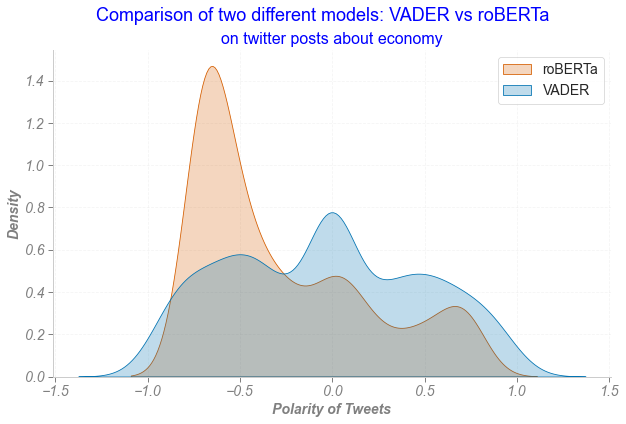

In [25]:
# Plotting the KDE Plot
fig = plt.figure(figsize=(10, 6))
sns.set("paper", "whitegrid", "colorblind")
sns.kdeplot(df["roberta_polarity"], color="r", shade=True, legend="roberta_polarity")
sns.kdeplot(df["vader_polarity"], color="b", shade=True, legend="vader_polaroty")
sns.despine(right=True, top=True)
plt.tick_params(
    reset=True,
    top=False,
    right=False,
    color="gray",
    labelcolor="gray",
    grid_alpha=0.2,
    grid_linestyle="--",
)
plt.xticks(**{"fontsize": 14, "font": "Arial", "fontstyle": "italic"})
plt.yticks(**{"fontsize": 14, "font": "Arial", "fontstyle": "italic"})
plt.xlabel(
    "Polarity of Tweets",
    font="Arial",
    fontstyle="italic",
    weight="bold",
    fontsize=14,
    color="gray",
)
plt.ylabel(
    "Density",
    font="Arial",
    fontstyle="italic",
    weight="bold",
    fontsize=14,
    color="gray",
)
plt.legend(["roBERTa", "VADER"], bbox_to_anchor=(1, 1.0), fontsize=14)
plt.suptitle(
    "Comparison of two different models: VADER vs roBERTa",
    fontsize=18,
    color="blue",
)
plt.title(
    "on twitter posts about economy",
    fontsize=16,
    color="blue",
)
plt.show()

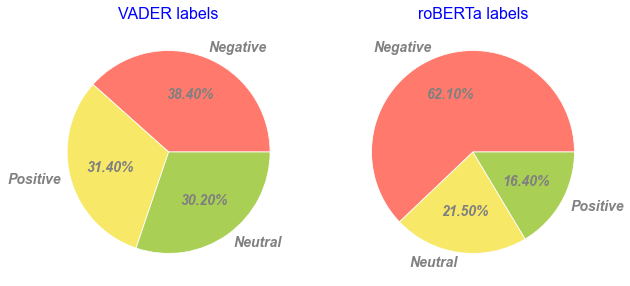

In [26]:
# creating a pie plots for count of sentiment labels
plt.figure(figsize=(10, 6))
plt.subplot(121)
df["vader_sentiment"].value_counts(normalize=True).to_frame().plot(
    ax=plt.gca(),
    kind="pie",
    autopct="%.2f%%",
    y="vader_sentiment",
    colors=["#ff7a6c", "#F7E967", "#A9CF54"],
    **{
        "textprops": {
            "fontsize": 14,
            "font": "Arial",
            "fontstyle": "italic",
            "weight": "bold",
            "color": "gray",
        }
    }
)
plt.legend().remove()
plt.title(
    "VADER labels",
    fontsize=16,
    color="blue",
)
plt.ylabel("")

# create the second pie plot
plt.subplot(122)
df["roberta_sentiment"].value_counts(normalize=True).to_frame().plot(
    ax=plt.gca(),
    kind="pie",
    autopct="%.2f%%",
    y="roberta_sentiment",
    # figsize=(5, 6),
    colors=["#ff7a6c", "#F7E967", "#A9CF54"],
    **{
        "textprops": {
            "fontsize": 14,
            "font": "Arial",
            "fontstyle": "italic",
            "weight": "bold",
            "color": "gray",
        }
    }
)
plt.legend().remove()
plt.title(
    "roBERTa labels",
    fontsize=16,
    color="blue",
)
plt.ylabel("")
plt.show()

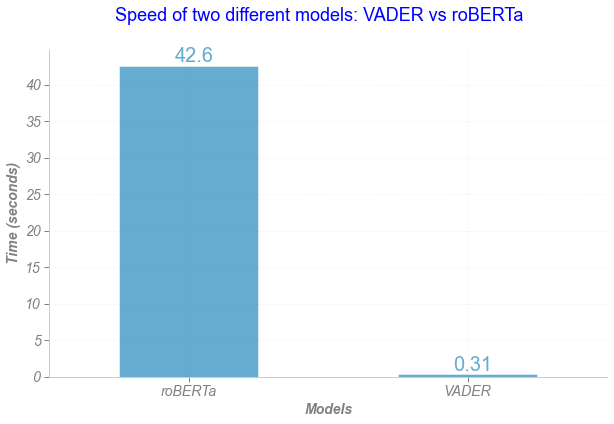

In [27]:
# bar chart to compare the speeds of the two models
pd.DataFrame({"model": ["roBERTa", "VADER"], "Prediction Time": [42.6, 0.31]}).plot(
    kind="bar", figsize=(10, 6), alpha=0.6, color="b"
)
sns.despine(right=True, top=True)
plt.tick_params(
    reset=True,
    top=False,
    right=False,
    color="gray",
    labelcolor="gray",
    grid_alpha=0.2,
    grid_linestyle="--",
)
plt.xticks(
    range(2),
    ["roBERTa", "VADER"],
    **{"fontsize": 14, "font": "Arial", "fontstyle": "italic"},
)
plt.yticks(**{"fontsize": 14, "font": "Arial", "fontstyle": "italic"})
plt.xlabel(
    "Models",
    font="Arial",
    fontstyle="italic",
    weight="bold",
    fontsize=14,
    color="gray",
)
plt.ylabel(
    "Time (seconds)",
    font="Arial",
    fontstyle="italic",
    weight="bold",
    fontsize=14,
    color="gray",
)
plt.legend("", frameon=False)
plt.suptitle(
    "Speed of two different models: VADER vs roBERTa",
    fontsize=18,
    color="blue",
)
for index, data in enumerate([42.6, 0.31]):
    plt.text(
        x=index - 0.05,
        y=data + 0.5,
        s=f"{data}",
        fontdict=dict(fontsize=20, color="b", alpha=0.6),
    )
plt.show()